In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.colors as mcolors

Prepare data

In [59]:
df = pd.read_csv('data/DatasetEV2.csv')
df = df[df["100% representative"] ==1]

df["carboxysome"] = df["carboxysome"].replace("0", "no carboxysome")
df["carboxysome"] = df["carboxysome"].replace("1", "carboxysome")

df['Rate mean [s-1]'] = df['Rate mean [s-1]'].astype(float)

my_pal = {"carboxysome": '#4cd456ff', "no carboxysome": '#d3d3d3ff'}

Statistical tests

In [60]:
group1 = df[df['carboxysome'] == 'carboxysome']['Rate mean [s-1]'].dropna()
group2 = df[df['carboxysome'] == 'no carboxysome']['Rate mean [s-1]'].dropna()

# Mann-Whitney U test
statistic, pvalue = mannwhitneyu(group1, group2)

if pvalue < 0.05:
    print(f'Mann-Whitney U test: The two groups are significantly different. p = {pvalue}')
else:
    print('Mann-Whitney U test: The two groups are not significantly different')  

Mann-Whitney U test: The two groups are significantly different. p = 2.797383595337412e-13


Plot

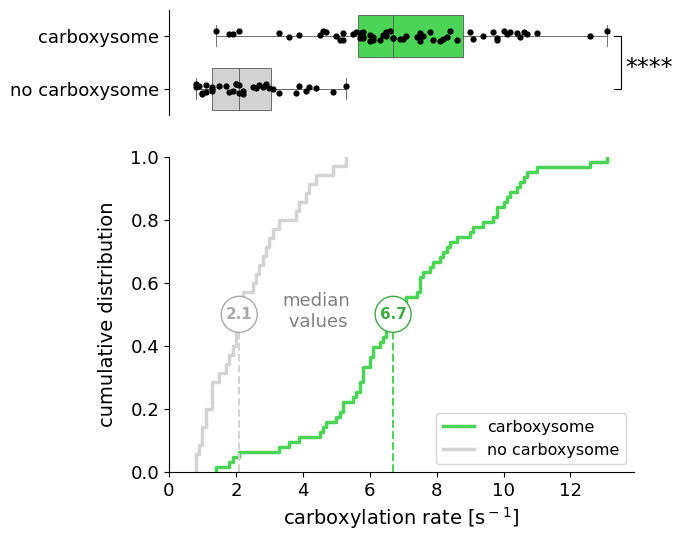

In [61]:
plt.rc('font', size=13)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), gridspec_kw={'height_ratios': [1, 3]})

# boxplot/swarmplot on first axis

sns.boxplot(data=df, x='Rate mean [s-1]', y='carboxysome', palette=my_pal, saturation=1, ax=axs[0], order=["carboxysome", "no carboxysome"], showfliers=False, linewidth=0.6)
sns.stripplot(data=df, x='Rate mean [s-1]', y='carboxysome', color='black', ax=axs[0], order=["carboxysome", "no carboxysome"], jitter=True, size=4.5)

axs[0].set_ylabel('')
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xlabel('')
axs[0].set(xticklabels=[])
axs[0].tick_params(bottom=False)
axs[0].set_xlim(0, 13.9)
axs[0].minorticks_off()

# cdf on second axis

ecdf = sns.ecdfplot(data=df, x='Rate mean [s-1]', hue='carboxysome', palette=my_pal, ax=axs[1], hue_order=["carboxysome", "no carboxysome"], linewidth=2.5)
ecdf.legend_.set_title("")

axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set_xlabel('carboxylation rate [s$^-$$^1$]', fontsize=14)
axs[1].set_ylabel('cumulative distribution', fontsize=14, labelpad=10)
axs[1].legend_.set_title("")
sns.move_legend(axs[1], "lower right", prop={'size': 11.5}, bbox_to_anchor=(1, 0))
axs[1].set_xlim(0, 13.9)

axs[0].set_facecolor('none')
axs[1].set_facecolor('none')

# Draw vertical lines from the x-axis to the curve at the x-coordinates
for curve, group in zip(axs[1].get_lines(), (group2, group1)):
    xcoord = np.median(group)
    ycoord = 0.5
    curve_color = mcolors.to_rgb(curve.get_color())  
    text_color = tuple(np.array(curve_color) * 0.8)
    axs[1].vlines(xcoord, 0, ycoord, color=curve_color, linestyle='dashed')
    # Use the original x-coordinate for the label
    axs[1].annotate(f'{xcoord:.1f}', xy=(xcoord, ycoord), xytext=(xcoord, ycoord),
                    color=text_color,
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor=text_color, boxstyle='circle,pad=0.3'))

# Add text next to the x-coordinates
axs[1].text(3.4, 0.46, 'median\n values', fontsize=13, color='grey')



# Add stars to box plot to indicate significance level
if pvalue <= 0.0001:
    star = '****'
elif pvalue <= 0.001:
    star = '***'
elif pvalue <= 0.01:
    star = '**'
elif pvalue <= 0.05:
    star = '*'
else:
    star = 'ns'
    
x1, x2 = 0, 1
y, h, col = df['Rate mean [s-1]'].max() + 0.1, 0.1, 'k'
axs[0].plot([13.3, 13.5, 13.5, 13.3], [0, 0, 1, 1], lw=.8, c = 'black')
axs[0].text(14.35, .81, star, ha='center', va='bottom', fontsize=17)

fig.patch.set_facecolor('none')
plt.savefig(r'plots/carbox_noncarbox_non_homog.svg', dpi=300, bbox_inches='tight')
plt.show()


Summary table

In [62]:
df['tested'] = ""

df_count_tested = df.groupby("carboxysome")["tested"].count().reset_index()

df_count_active = df.groupby("carboxysome")['Rate mean [s-1]'].count().reset_index()
df_count_active.rename(columns={'Rate mean [s-1]': 'active'}, inplace=True)

df_count_medianrate = df.groupby("carboxysome")['Rate mean [s-1]'].median().reset_index()
df_count_medianrate.rename(columns={'Rate mean [s-1]': 'median rate'}, inplace=True)

df_count_stdev = df.groupby("carboxysome")['Rate mean [s-1]'].std().reset_index()
df_count_stdev.rename(columns={'Rate mean [s-1]': 'standard deviation'}, inplace=True)

df_count_iqr1 = df.groupby("carboxysome")['Rate mean [s-1]'].quantile(0.25).reset_index()
df_count_iqr1.rename(columns={'Rate mean [s-1]': 'IQR1'}, inplace=True)

df_count_iqr3 = df.groupby("carboxysome")['Rate mean [s-1]'].quantile(0.75).reset_index()
df_count_iqr3.rename(columns={'Rate mean [s-1]': 'IQR3'}, inplace=True)


df_count = pd.merge(df_count_tested, df_count_active, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_medianrate, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_stdev, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_iqr1, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_iqr3, on=['carboxysome'])

df_count['%clustering'] = ["85%", "75%"] 

print(df_count)


      carboxysome  tested  active  median rate  standard deviation  IQR1  \
0     carboxysome      82      63          6.7             2.55386  5.65   
1  no carboxysome      61      35          2.1             1.23664  1.30   

   IQR3 %clustering  
0  8.80         85%  
1  3.05         75%  


With homogenous representation of groups - SI

In [63]:
df = df[df["85% carboxysome, 75%no carboxysome"] == 1]

Statistical tests

In [64]:
group1 = df[df['carboxysome'] == 'carboxysome']['Rate mean [s-1]'].dropna()
group2 = df[df['carboxysome'] == 'no carboxysome']['Rate mean [s-1]'].dropna()

# Mann-Whitney U test
statistic, pvalue = mannwhitneyu(group1, group2)

if pvalue < 0.05:
    print(f'Mann-Whitney U test: The two groups are significantly different. p = {pvalue}')
else:
    print('Mann-Whitney U test: The two groups are not significantly different')  

Mann-Whitney U test: The two groups are significantly different. p = 0.0010797905502020965


Plot

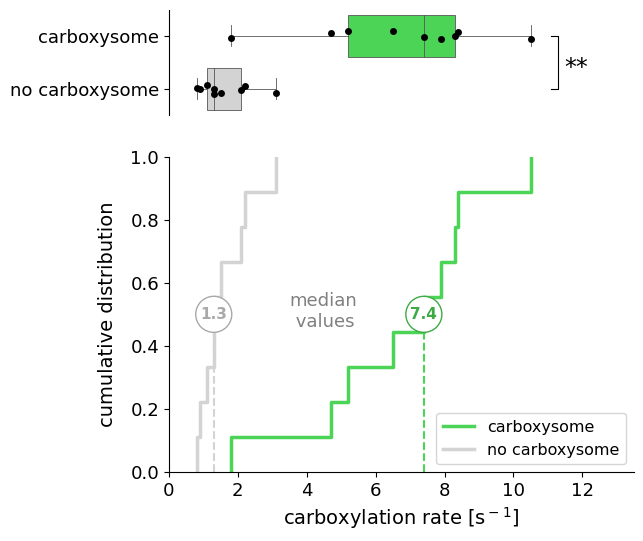

In [65]:
plt.rc('font', size=13)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), gridspec_kw={'height_ratios': [1, 3]})

# boxplot/swarmplot on first axis

sns.boxplot(data=df, x='Rate mean [s-1]', y='carboxysome', palette=my_pal, saturation=1, ax=axs[0], order=["carboxysome", "no carboxysome"], showfliers=False, linewidth=0.6)
sns.stripplot(data=df, x='Rate mean [s-1]', y='carboxysome', color='black', ax=axs[0], order=["carboxysome", "no carboxysome"], jitter=True, size=5)

axs[0].set_ylabel('')
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xlabel('')
axs[0].set(xticklabels=[])
axs[0].tick_params(bottom=False)
axs[0].set_xlim(0, 13.5)
axs[0].minorticks_off()

# cdf on second axis

ecdf = sns.ecdfplot(data=df, x='Rate mean [s-1]', hue='carboxysome', palette=my_pal, ax=axs[1], hue_order=["carboxysome", "no carboxysome"], linewidth=2.5)
ecdf.legend_.set_title("")

axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set_xlabel('carboxylation rate [s$^-$$^1$]', fontsize=14)
axs[1].set_ylabel('cumulative distribution', fontsize=14, labelpad=10)
axs[1].legend_.set_title("")
sns.move_legend(axs[1], "lower right", prop={'size': 11.5}, bbox_to_anchor=(1, 0))
axs[1].set_xlim(0, 13.5)


axs[0].set_facecolor('none')
axs[1].set_facecolor('none')

# Draw vertical lines from the x-axis to the curve at the x-coordinates
for curve, group in zip(axs[1].get_lines(), (group2, group1)):
    xcoord = np.median(group)
    ycoord = 0.5
    curve_color = mcolors.to_rgb(curve.get_color())  
    text_color = tuple(np.array(curve_color) * 0.8)
    axs[1].vlines(xcoord, 0, ycoord, color=curve_color, linestyle='dashed')
    # Use the original x-coordinate for the label
    axs[1].annotate(f'{xcoord:.1f}', xy=(xcoord, ycoord), xytext=(xcoord, ycoord),
                    color=text_color,
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor=text_color, boxstyle='circle,pad=0.3'))

# Add text next to the x-coordinates
axs[1].text(3.5, 0.46, 'median\n values', fontsize=13, color='grey')



# Add stars to box plot to indicate significance level
if pvalue <= 0.0001:
    star = '****'
elif pvalue <= 0.001:
    star = '***'
elif pvalue <= 0.01:
    star = '**'
elif pvalue <= 0.05:
    star = '*'
else:
    star = 'ns'
    
x1, x2 = 0, 1
y, h, col = df['Rate mean [s-1]'].max() + 0.1, 0.1, 'k'
axs[0].plot([11.1, 11.3, 11.3, 11.1], [0, 0, 1, 1], lw=.8, c = 'black')
axs[0].text(11.81, .82, star, ha='center', va='bottom', fontsize=17)

fig.patch.set_facecolor('none')
plt.savefig(r'plots/carbox_noncarbox_homog.svg', dpi=300, bbox_inches='tight')
plt.show()


Summary table

In [66]:
df['tested'] = ""

df_count_tested = df.groupby("carboxysome")["tested"].count().reset_index()

df_count_active = df.groupby("carboxysome")['Rate mean [s-1]'].count().reset_index()
df_count_active.rename(columns={'Rate mean [s-1]': 'active'}, inplace=True)

df_count_medianrate = df.groupby("carboxysome")['Rate mean [s-1]'].median().reset_index()
df_count_medianrate.rename(columns={'Rate mean [s-1]': 'median rate'}, inplace=True)

df_count_stdev = df.groupby("carboxysome")['Rate mean [s-1]'].std().reset_index()
df_count_stdev.rename(columns={'Rate mean [s-1]': 'standard deviation'}, inplace=True)

df_count_iqr1 = df.groupby("carboxysome")['Rate mean [s-1]'].quantile(0.25).reset_index()
df_count_iqr1.rename(columns={'Rate mean [s-1]': 'IQR1'}, inplace=True)

df_count_iqr3 = df.groupby("carboxysome")['Rate mean [s-1]'].quantile(0.75).reset_index()
df_count_iqr3.rename(columns={'Rate mean [s-1]': 'IQR3'}, inplace=True)


df_count = pd.merge(df_count_tested, df_count_active, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_medianrate, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_stdev, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_iqr1, on=['carboxysome'])
df_count = pd.merge(df_count, df_count_iqr3, on=['carboxysome'])

df_count['%clustering'] = ["85%", "75%"] 

print(df_count)


      carboxysome  tested  active  median rate  standard deviation  IQR1  \
0     carboxysome      15       9          7.4            2.552014   5.2   
1  no carboxysome      29       9          1.3            0.744050   1.1   

   IQR3 %clustering  
0   8.3         85%  
1   2.1         75%  
